# Find the CO2 capture Pareto front

In [12]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import GPy
import matplotlib.pyplot as plt 
%matplotlib inline

from dispersant_screener.gp import build_model, build_coregionalized_model, predict_coregionalized, set_xy_coregionalized
from dispersant_screener.pal import pal_evaluate as pal
from dispersant_screener.utils import get_kmeans_samples, get_maxmin_samples

import numpy as np

In [13]:
other_descriptors = ['CellV [A^3]']

geometric_descirptors = [
 'Di',
 'Df',
 'Dif',
 'density [g/cm^3]',
 'total_SA_volumetric',
 'total_SA_gravimetric',
 'total_POV_volumetric',
 'total_POV_gravimetric'
 ]

linker_descriptors = [
 'f-lig-chi-0',
 'f-lig-chi-1',
 'f-lig-chi-2',
 'f-lig-chi-3',
 'f-lig-Z-0',
 'f-lig-Z-1',
 'f-lig-Z-2',
 'f-lig-Z-3',
 'f-lig-I-0',
 'f-lig-I-1',
 'f-lig-I-2',
 'f-lig-I-3',
 'f-lig-T-0',
 'f-lig-T-1',
 'f-lig-T-2',
 'f-lig-T-3',
 'f-lig-S-0',
 'f-lig-S-1',
 'f-lig-S-2',
 'f-lig-S-3',
 'lc-chi-0-all',
 'lc-chi-1-all',
 'lc-chi-2-all',
 'lc-chi-3-all',
 'lc-Z-0-all',
 'lc-Z-1-all',
 'lc-Z-2-all',
 'lc-Z-3-all',
 'lc-I-0-all',
 'lc-I-1-all',
 'lc-I-2-all',
 'lc-I-3-all',
 'lc-T-0-all',
 'lc-T-1-all',
 'lc-T-2-all',
 'lc-T-3-all',
 'lc-S-0-all',
 'lc-S-1-all',
 'lc-S-2-all',
 'lc-S-3-all',
 'lc-alpha-0-all',
 'lc-alpha-1-all',
 'lc-alpha-2-all',
 'lc-alpha-3-all',
 'D_lc-chi-0-all',
 'D_lc-chi-1-all',
 'D_lc-chi-2-all',
 'D_lc-chi-3-all',
 'D_lc-Z-0-all',
 'D_lc-Z-1-all',
 'D_lc-Z-2-all',
 'D_lc-Z-3-all',
 'D_lc-I-0-all',
 'D_lc-I-1-all',
 'D_lc-I-2-all',
 'D_lc-I-3-all',
 'D_lc-T-0-all',
 'D_lc-T-1-all',
 'D_lc-T-2-all',
 'D_lc-T-3-all',
 'D_lc-S-0-all',
 'D_lc-S-1-all',
 'D_lc-S-2-all',
 'D_lc-S-3-all',
 'D_lc-alpha-0-all',
 'D_lc-alpha-1-all',
 'D_lc-alpha-2-all',
 'D_lc-alpha-3-all']

metalcenter_descriptors =[
 'mc_CRY-chi-0-all',
 'mc_CRY-chi-1-all',
 'mc_CRY-chi-2-all',
 'mc_CRY-chi-3-all',
 'mc_CRY-Z-0-all',
 'mc_CRY-Z-1-all',
 'mc_CRY-Z-2-all',
 'mc_CRY-Z-3-all',
 'mc_CRY-I-0-all',
 'mc_CRY-I-1-all',
 'mc_CRY-I-2-all',
 'mc_CRY-I-3-all',
 'mc_CRY-T-0-all',
 'mc_CRY-T-1-all',
 'mc_CRY-T-2-all',
 'mc_CRY-T-3-all',
 'mc_CRY-S-0-all',
 'mc_CRY-S-1-all',
 'mc_CRY-S-2-all',
 'mc_CRY-S-3-all',
 'D_mc_CRY-chi-0-all',
 'D_mc_CRY-chi-1-all',
 'D_mc_CRY-chi-2-all',
 'D_mc_CRY-chi-3-all',
 'D_mc_CRY-Z-0-all',
 'D_mc_CRY-Z-1-all',
 'D_mc_CRY-Z-2-all',
 'D_mc_CRY-Z-3-all',
 'D_mc_CRY-I-0-all',
 'D_mc_CRY-I-1-all',
 'D_mc_CRY-I-2-all',
 'D_mc_CRY-I-3-all',
 'D_mc_CRY-T-0-all',
 'D_mc_CRY-T-1-all',
 'D_mc_CRY-T-2-all',
 'D_mc_CRY-T-3-all',
 'D_mc_CRY-S-0-all',
 'D_mc_CRY-S-1-all',
 'D_mc_CRY-S-2-all',
 'D_mc_CRY-S-3-all']

functionalgroup_descriptors = [
 'func-chi-0-all',
 'func-chi-1-all',
 'func-chi-2-all',
 'func-chi-3-all',
 'func-Z-0-all',
 'func-Z-1-all',
 'func-Z-2-all',
 'func-Z-3-all',
 'func-I-0-all',
 'func-I-1-all',
 'func-I-2-all',
 'func-I-3-all',
 'func-T-0-all',
 'func-T-1-all',
 'func-T-2-all',
 'func-T-3-all',
 'func-S-0-all',
 'func-S-1-all',
 'func-S-2-all',
 'func-S-3-all',
 'func-alpha-0-all',
 'func-alpha-1-all',
 'func-alpha-2-all',
 'func-alpha-3-all',
 'D_func-chi-0-all',
 'D_func-chi-1-all',
 'D_func-chi-2-all',
 'D_func-chi-3-all',
 'D_func-Z-0-all',
 'D_func-Z-1-all',
 'D_func-Z-2-all',
 'D_func-Z-3-all',
 'D_func-I-0-all',
 'D_func-I-1-all',
 'D_func-I-2-all',
 'D_func-I-3-all',
 'D_func-T-0-all',
 'D_func-T-1-all',
 'D_func-T-2-all',
 'D_func-T-3-all',
 'D_func-S-0-all',
 'D_func-S-1-all',
 'D_func-S-2-all',
 'D_func-S-3-all',
 'D_func-alpha-0-all',
 'D_func-alpha-1-all',
 'D_func-alpha-2-all',
 'D_func-alpha-3-all']


summed_linker_descriptors = [
 'sum-f-lig-chi-0',
 'sum-f-lig-chi-1',
 'sum-f-lig-chi-2',
 'sum-f-lig-chi-3',
 'sum-f-lig-Z-0',
 'sum-f-lig-Z-1',
 'sum-f-lig-Z-2',
 'sum-f-lig-Z-3',
 'sum-f-lig-I-0',
 'sum-f-lig-I-1',
 'sum-f-lig-I-2',
 'sum-f-lig-I-3',
 'sum-f-lig-T-0',
 'sum-f-lig-T-1',
 'sum-f-lig-T-2',
 'sum-f-lig-T-3',
 'sum-f-lig-S-0',
 'sum-f-lig-S-1',
 'sum-f-lig-S-2',
 'sum-f-lig-S-3',
 'sum-lc-chi-0-all',
 'sum-lc-chi-1-all',
 'sum-lc-chi-2-all',
 'sum-lc-chi-3-all',
 'sum-lc-Z-0-all',
 'sum-lc-Z-1-all',
 'sum-lc-Z-2-all',
 'sum-lc-Z-3-all',
 'sum-lc-I-0-all',
 'sum-lc-I-1-all',
 'sum-lc-I-2-all',
 'sum-lc-I-3-all',
 'sum-lc-T-0-all',
 'sum-lc-T-1-all',
 'sum-lc-T-2-all',
 'sum-lc-T-3-all',
 'sum-lc-S-0-all',
 'sum-lc-S-1-all',
 'sum-lc-S-2-all',
 'sum-lc-S-3-all',
 'sum-lc-alpha-0-all',
 'sum-lc-alpha-1-all',
 'sum-lc-alpha-2-all',
 'sum-lc-alpha-3-all',
 'sum-D_lc-chi-0-all',
 'sum-D_lc-chi-1-all',
 'sum-D_lc-chi-2-all',
 'sum-D_lc-chi-3-all',
 'sum-D_lc-Z-0-all',
 'sum-D_lc-Z-1-all',
 'sum-D_lc-Z-2-all',
 'sum-D_lc-Z-3-all',
 'sum-D_lc-I-0-all',
 'sum-D_lc-I-1-all',
 'sum-D_lc-I-2-all',
 'sum-D_lc-I-3-all',
 'sum-D_lc-T-0-all',
 'sum-D_lc-T-1-all',
 'sum-D_lc-T-2-all',
 'sum-D_lc-T-3-all',
 'sum-D_lc-S-0-all',
 'sum-D_lc-S-1-all',
 'sum-D_lc-S-2-all',
 'sum-D_lc-S-3-all',
 'sum-D_lc-alpha-0-all',
 'sum-D_lc-alpha-1-all',
 'sum-D_lc-alpha-2-all',
 'sum-D_lc-alpha-3-all']

summed_metalcenter_descriptors =[
 'sum-mc_CRY-chi-0-all',
 'sum-mc_CRY-chi-1-all',
 'sum-mc_CRY-chi-2-all',
 'sum-mc_CRY-chi-3-all',
 'sum-mc_CRY-Z-0-all',
 'sum-mc_CRY-Z-1-all',
 'sum-mc_CRY-Z-2-all',
 'sum-mc_CRY-Z-3-all',
 'sum-mc_CRY-I-0-all',
 'sum-mc_CRY-I-1-all',
 'sum-mc_CRY-I-2-all',
 'sum-mc_CRY-I-3-all',
 'sum-mc_CRY-T-0-all',
 'sum-mc_CRY-T-1-all',
 'sum-mc_CRY-T-2-all',
 'sum-mc_CRY-T-3-all',
 'sum-mc_CRY-S-0-all',
 'sum-mc_CRY-S-1-all',
 'sum-mc_CRY-S-2-all',
 'sum-mc_CRY-S-3-all',
 'sum-D_mc_CRY-chi-0-all',
 'sum-D_mc_CRY-chi-1-all',
 'sum-D_mc_CRY-chi-2-all',
 'sum-D_mc_CRY-chi-3-all',
 'sum-D_mc_CRY-Z-0-all',
 'sum-D_mc_CRY-Z-1-all',
 'sum-D_mc_CRY-Z-2-all',
 'sum-D_mc_CRY-Z-3-all',
 'sum-D_mc_CRY-I-0-all',
 'sum-D_mc_CRY-I-1-all',
 'sum-D_mc_CRY-I-2-all',
 'sum-D_mc_CRY-I-3-all',
 'sum-D_mc_CRY-T-0-all',
 'sum-D_mc_CRY-T-1-all',
 'sum-D_mc_CRY-T-2-all',
 'sum-D_mc_CRY-T-3-all',
 'sum-D_mc_CRY-S-0-all',
 'sum-D_mc_CRY-S-1-all',
 'sum-D_mc_CRY-S-2-all',
 'sum-D_mc_CRY-S-3-all']

summed_functionalgroup_descriptors = [
 'sum-func-chi-0-all',
 'sum-func-chi-1-all',
 'sum-func-chi-2-all',
 'sum-func-chi-3-all',
 'sum-func-Z-0-all',
 'sum-func-Z-1-all',
 'sum-func-Z-2-all',
 'sum-func-Z-3-all',
 'sum-func-I-0-all',
 'sum-func-I-1-all',
 'sum-func-I-2-all',
 'sum-func-I-3-all',
 'sum-func-T-0-all',
 'sum-func-T-1-all',
 'sum-func-T-2-all',
 'sum-func-T-3-all',
 'sum-func-S-0-all',
 'sum-func-S-1-all',
 'sum-func-S-2-all',
 'sum-func-S-3-all',
 'sum-func-alpha-0-all',
 'sum-func-alpha-1-all',
 'sum-func-alpha-2-all',
 'sum-func-alpha-3-all',
 'sum-D_func-chi-0-all',
 'sum-D_func-chi-1-all',
 'sum-D_func-chi-2-all',
 'sum-D_func-chi-3-all',
 'sum-D_func-Z-0-all',
 'sum-D_func-Z-1-all',
 'sum-D_func-Z-2-all',
 'sum-D_func-Z-3-all',
 'sum-D_func-I-0-all',
 'sum-D_func-I-1-all',
 'sum-D_func-I-2-all',
 'sum-D_func-I-3-all',
 'sum-D_func-T-0-all',
 'sum-D_func-T-1-all',
 'sum-D_func-T-2-all',
 'sum-D_func-T-3-all',
 'sum-D_func-S-0-all',
 'sum-D_func-S-1-all',
 'sum-D_func-S-2-all',
 'sum-D_func-S-3-all',
 'sum-D_func-alpha-0-all',
 'sum-D_func-alpha-1-all',
 'sum-D_func-alpha-2-all',
 'sum-D_func-alpha-3-all']


In [14]:
pmof_test = pd.read_csv('/Users/kevinmaikjablonka/Dropbox (LSMO)/proj70_diversity_mohamad/PMOF20K_traindata_7000_test.csv')

In [15]:
pmof_train = pd.read_csv('/Users/kevinmaikjablonka/Dropbox (LSMO)/proj70_diversity_mohamad/PMOF20K_traindata_7000_train.csv')

In [16]:
pmof = pd.concat([pmof_test, pmof_train])

In [17]:
pmof['CO2_DC'] = pmof['pure_uptake_CO2_298.00_1600000'] - pmof['pure_uptake_CO2_298.00_15000']

In [18]:
y = pmof[['CO2_DC', 'CH4DC']].values

In [81]:
feat = set(
["func-chi-0-all" ,"D_func-S-3-all", "total_SA_volumetric", 
 "Di", "Dif", "mc_CRY-Z-0-all","total_POV_volumetric","density [g/cm^3]", "total_SA_gravimetric",
 "D_func-S-1-all","Df", "mc_CRY-S-0-all" ,"total_POV_gravimetric","D_func-alpha-1-all","func-S-0-all",
 "D_mc_CRY-chi-3-all","D_mc_CRY-chi-1-all","func-alpha-0-all",
 "D_mc_CRY-T-2-all","mc_CRY-Z-2-all","D_mc_CRY-chi-2-all",
"total_SA_gravimetric","total_POV_gravimetric","Di","density [g/cm^3]",
 "func-S-0-all",
 "func-chi-2-all","func-alpha-0-all",
 "total_POV_volumetric",
 "D_func-alpha-1-all",
 "total_SA_volumetric",
 "func-alpha-1-all",
 "func-alpha-3-all",
 "Dif",
 "Df",
 "func-chi-3-all", 
  'Di',
 'Df',
 'Dif',
 'density [g/cm^3]',
])

In [82]:
X = pmof[feat]

In [83]:
X = StandardScaler().fit_transform(X)
X = VarianceThreshold(0.1).fit_transform(X)

In [84]:
X_train, y_train, indices = get_maxmin_samples(X, y, 250)

100%|█████████▉| 249/250 [00:27<00:00,  9.22it/s]


In [85]:
model = build_coregionalized_model(X_train, y_train, kernel=GPy.kern.Matern32(X_train.shape[1], ARD=True))

In [86]:
model

gp.,value,constraints,priors
ICM.Mat32.variance,1.0,+ve fixed,
ICM.Mat32.lengthscale,"(25,)",+ve,
ICM.B.W,"(2, 1)",,
ICM.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.01,+ve,
mixed_noise.Gaussian_noise_1.variance,0.01,+ve,


In [87]:
model['.*Gaussian_noise_*'] = 0.01

In [93]:
model.optimize_restarts()

Optimization restart 1/10, f = -559.0897253301601
Optimization restart 2/10, f = -486.1578265933549
Optimization restart 3/10, f = -483.8138278466422
Optimization restart 4/10, f = -473.35474304600586
Optimization restart 5/10, f = -476.5088626970908
Optimization restart 6/10, f = -463.80636270237795
Optimization restart 7/10, f = -480.8547926820555
Optimization restart 8/10, f = -487.1331451572503
Optimization restart 9/10, f = -476.46270497894693
Optimization restart 10/10, f = -485.98729832862114


In [94]:
model

gp.,value,constraints,priors
ICM.Mat32.variance,1.0,+ve fixed,
ICM.Mat32.lengthscale,"(25,)",+ve,
ICM.B.W,"(2, 1)",,
ICM.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,2.3564923415271213e-35,+ve,
mixed_noise.Gaussian_noise_1.variance,0.03542444836528385,+ve,


In [95]:
X_test = np.delete(X, indices, 0)
y_test = np.delete(y, indices, 0)

In [96]:
pred, var = predict_coregionalized(model, X_test, 1)

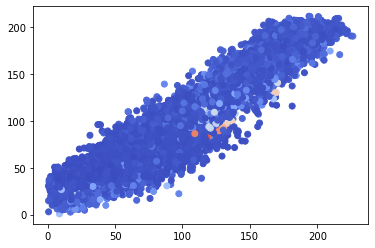

In [97]:
plt.scatter(y_test[:,1], pred, c=var, cmap='coolwarm')

In [17]:
models = [
    build_coregionalized_model(X_train, y_train, kernel = GPy.kern.RBF(X_train.shape[1], ARD=False))
]

In [18]:
pareto_optimal, hypervolumes, gps, sampled = pal(models, X_train, y_train, X_test, y_test, 
                                        hv_reference=[5, 5], iterations=1000, verbosity='info',
                                        epsilon=[0.05, 0.05], delta=0.05, beta_scale=1/16, coregionalized=True)

2020-08-16 08:57:39,558 PALlogger    INFO     Starting now the PAL loop
  0%|          | 0/1000 [00:00<?, ?it/s] /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/GPy/util/multioutput.py:83: UserWarning:kernel's input dimension overwritten to fit input_dim parameter.


Optimization restart 1/5, f = 111.41946287997175
Optimization restart 2/5, f = 111.41946290695348
Optimization restart 3/5, f = 111.41946288970506
Optimization restart 4/5, f = 111.4194629151374
Optimization restart 5/5, f = 111.41946288441072


 /Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/pal.py:263: NumbaWarning:
Compilation is falling back to object mode WITH looplifting enabled because Function "_pareto_classify" failed type inference due to: Untyped global name 'sum': cannot determine Numba type of <class 'builtin_function_or_method'>

File "../dispersant_screener/pal.py", line 291:
def _pareto_classify(  # pylint:disable=too-many-arguments
    <source elided>
    # first check the pareto pessimistic front of pareto_optimal_t
    if sum(pareto_optimal_0) > 0:
    ^

 /Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/pal.py:263: NumbaWarning:
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_pareto_classify" failed type inference due to: Untyped global name 'sum': cannot determine Numba type of <class 'builtin_function_or_method'>

File "../dispersant_screener/pal.py", line 291:
def _pareto_classify(  # pylin

Optimization restart 1/5, f = 118.8115588794629
Optimization restart 2/5, f = 138.51534512872882
Optimization restart 3/5, f = 118.81155887499733
Optimization restart 4/5, f = 138.51533690247
Optimization restart 5/5, f = 118.81155894665747


2020-08-16 09:00:01,249 PALlogger    INFO     Iteration 2 | Pareto optimal 0, not Pareto optimal 0, unclassified 17379, hypervolume: nan
  0%|          | 2/1000 [02:21<19:50:21, 71.56s/it] /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/GPy/util/multioutput.py:83: UserWarning:kernel's input dimension overwritten to fit input_dim parameter.


Optimization restart 1/5, f = 126.06589119976952
Optimization restart 2/5, f = 146.17667781524386
Optimization restart 3/5, f = 126.06589123927913
Optimization restart 4/5, f = 146.17663346090256
Optimization restart 5/5, f = 126.06589130173926


2020-08-16 09:01:09,281 PALlogger    INFO     Iteration 3 | Pareto optimal 0, not Pareto optimal 0, unclassified 17379, hypervolume: nan
  0%|          | 3/1000 [03:29<19:31:33, 70.51s/it]

Ctrl+c received, terminating and joining pool.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-36d594e6f2d3>", line 3, in <module>
    epsilon=[0.05, 0.05], delta=0.05, beta_scale=1/16, coregionalized=True)
  File "/Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/pal.py", line 540, in pal
    mus, stds, gps = _get_gp_predictions(gps, x_train, y_train, x_input, coregionalized, optimize)
  File "/Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/pal.py", line 109, in _get_gp_predictions
    gp.optimize()
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/paramz/model.py", line 182, in optimize_restarts
    raise e
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-p

UnboundLocalError: local variable 'jobs' referenced before assignment

In [17]:
x_train = np.load('../work/x_train.npy')
x_test = np.load('../work/x_test.npy')
pareto = np.load('../work/pareto_optimal.npy')

y_train = np.load('../work/y_train.npy')
y_test = np.load('../work/y_test.npy')

In [18]:
X = np.vstack([x_test, x_train])
y = np.vstack([y_test, y_train])

In [19]:
selected_indices = np.where(np.array(pareto)==1)[0]

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


Text(0, 0.5, 'DC CO$_2$')

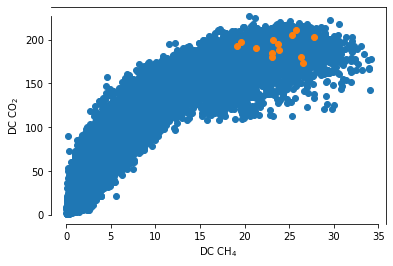

In [20]:
fig, ax = plt.subplots(1,1)

ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)


ax.scatter(y[:,0], y[:,1])
ax.scatter(y[selected_indices,0], y[selected_indices,1])


ax.set_xlabel('DC CH$_4$')
ax.set_ylabel('DC CO$_2$')

In [ ]:
len(pareto_optimal)

In [12]:
from dispersant_screener.pal import get_hypervolume
from dispersant_screener.utils import is_pareto_efficient

In [15]:
y = StandardScaler().fit_transform(y)

In [16]:
pareto_true = is_pareto_efficient(-y)

In [17]:
get_hypervolume(y[pareto_true], [5,5])

54.87275962497361

In [ ]:
get_hypervolume(y[pareto_true], [5,5])

In [78]:
get_hypervolume(y[selected_indices], [5,5])

6018.3030861096095

In [46]:
(8223.597174801002- 8890.466868350813)/8199.22753403605

-0.08133323423231638

In [45]:
sum(pareto_true)

8